In [18]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, BatchNormalization
from keras.layers import Input, Flatten, Embedding, multiply, Dropout
from keras.optimizers import Adam
from keras import initializers

from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Concatenate, GaussianNoise
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras import losses
from keras.utils import to_categorical
import keras.backend as K

# from scipy.misc import imresize
from skimage.transform import resize

In [17]:
# !pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-1md84fsa
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-1md84fsa
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101066 sha256=bacbd5808bfc5f4463b452887ce803da96143d702fed6a88094803a3a64c9c6b
  Stored in directory: /tmp/pip-ephem-wheel-cache-e4ozgieu/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib
You should consider upgrading via the 'pip install --upgrade pip' command.


a simple semi-supervised learning approach for images based on
in-painting using an adversarial loss. Images with random patches removed are
presented to a generator whose task is to fill in the hole, based on the surrounding
pixels. The in-painted images are then presented to a discriminator network that
judges if they are real (unaltered training images) or not. This task acts as a regularizer for standard supervised training of the discriminator.

In [3]:
# load dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [12]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [4]:
X_train.shape,X_test.shape

((60000, 28, 28), (10000, 28, 28))

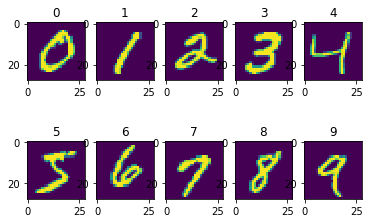

In [5]:
fig = plt.figure()
for i in range(10):
    plt.subplot(2,5,i+1)
    examp = X_train[y_train == i][0]
    plt.imshow(examp)
    plt.title(str(i))

In [9]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)

X_train = np.float32(X_train)
X_train = (X_train / 255 - 0.5) * 2
X_train = np.clip(X_train, -1, 1)

# y to categorical
num_classes = 10
y_train = to_categorical(y_train, num_classes=num_classes+1)

print('X_train reshape:', X_train.shape)
print('y_train reshape:', y_train.shape)

X_train reshape: (60000, 28, 28, 1)
y_train reshape: (60000, 11)


In [10]:
X_train = resize(X_train, [X_train.shape[0], 32, 32, 1])
print('X_train reshape:', X_train.shape)

X_train reshape: (60000, 32, 32, 1)


In [14]:
y_train[:10]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [19]:
# Discriminator network
k = 4
img_shape = X_train[0].shape

discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=k, strides=2, padding='same', input_shape=img_shape))
discriminator.add(LeakyReLU(alpha=0.8))
discriminator.add(Conv2D(128, kernel_size=k, strides=2, padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(InstanceNormalization())
discriminator.add(Conv2D(256, kernel_size=k, strides=2, padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(InstanceNormalization())

img_d = Input(shape=img_shape)
features = discriminator(img_d)

validity = Conv2D(1, kernel_size=k, strides=1, padding='same')(features)
# validity = Flatten()(validity)
# validity = Dense(1, activation='sigmoid')(validity)

label = Flatten()(features)
label = Dense(num_classes+1, activation="softmax")(label)

discriminator = Model(img_d, [validity, label])
discriminator.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 4, 4, 256)    656836      input_1[0][0]                    
__________________________________________________________________________________________________
flatten (Flatten)               (None, 4096)         0           sequential_1[0][0]               
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 4, 4, 1)      4097        sequential_1[0][0]               
_______________________________________________________________________________________

In [20]:
# Optimizer
optimizer = Adam(lr=0.0002, beta_1=0.5)

discriminator.compile(optimizer=optimizer, loss=['mse', 'categorical_crossentropy'],
                      loss_weights=[0.5, 0.5], metrics=['accuracy'])

In [22]:
# Number of filters in first layer of generator
gf = 32
k = 4
s = 2

# imagem shape 28x28x1
img_shape = X_train[0].shape

# Generator input
img_g = Input(shape=(img_shape))

# Downsampling
d1 = Conv2D(gf, kernel_size=k, strides=s, padding='same')(img_g)
d1 = LeakyReLU(alpha=0.2)(d1)

d2 = Conv2D(gf*2, kernel_size=k, strides=s, padding='same')(d1)
d2 = LeakyReLU(alpha=0.2)(d2)
d2 = BatchNormalization(momentum=0.8)(d2)

d3 = Conv2D(gf*4, kernel_size=k, strides=s, padding='same')(d2)
d3 = LeakyReLU(alpha=0.2)(d3)
d3 = BatchNormalization(momentum=0.8)(d3)

d4 = Conv2D(gf*8, kernel_size=k, strides=s, padding='same')(d3)
d4 = LeakyReLU(alpha=0.2)(d4)
d4 = BatchNormalization(momentum=0.8)(d4)

# Upsampling
u1 = UpSampling2D(size=2)(d4)
u1 = Conv2D(gf*4, kernel_size=k, strides=1, padding='same', activation='relu')(u1)
u1 = BatchNormalization(momentum=0.8)(u1)

u2 = Concatenate()([u1, d3])
u2 = UpSampling2D(size=2)(u2)
u2 = Conv2D(gf*2, kernel_size=k, strides=1, padding='same', activation='relu')(u2)
u2 = BatchNormalization(momentum=0.8)(u2)

u3 = Concatenate()([u2, d2])
u3 = UpSampling2D(size=2)(u3)
u3 = Conv2D(gf, kernel_size=k, strides=1, padding='same', activation='relu')(u3)
u3 = BatchNormalization(momentum=0.8)(u3)

u4 = Concatenate()([u3, d1])
u4 = UpSampling2D(size=2)(u4)
u4 = Conv2D(1, kernel_size=4, strides=1, padding='same', activation='tanh')(u4)

generator = Model(img_g, u4)
generator.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 16, 16, 32)   544         input_3[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_7 (LeakyReLU)       (None, 16, 16, 32)   0           conv2d_12[0][0]                  
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 8, 8, 64)     32832       leaky_re_lu_7[0][0]              
_______________________________________________________________________________________

In [23]:
# The generator takes noise as input and generates imgs
masked_img = Input(shape=(img_shape))
gen_img = generator(masked_img)

# For the combined model we will only train the generator
discriminator.trainable = False

validity, _ = discriminator(gen_img)

d_g = Model(masked_img, validity)

d_g.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])

In [24]:
def mask_randomly(imgs, mask_width=10, mask_height=10):
    y1 = np.random.randint(0, imgs.shape[1] - mask_height, imgs.shape[0])
    y2 = y1 + mask_height
    x1 = np.random.randint(0, imgs.shape[2] - mask_width, imgs.shape[0])
    x2 = x1 + mask_width

    masked_imgs = np.empty_like(imgs)
    for i, img in enumerate(imgs):
        masked_img = img.copy()
        _y1, _y2, _x1, _x2 = y1[i], y2[i], x1[i], x2[i],
        masked_img[_y1:_y2, _x1:_x2, :] = 0
        masked_imgs[i] = masked_img

    return masked_imgs

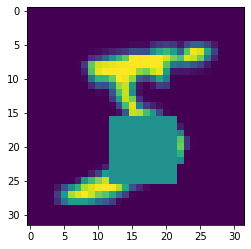

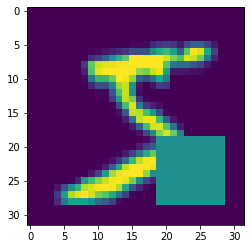

In [25]:
plt.imshow(mask_randomly(X_train[0:1])[0].reshape(32, 32))
plt.show()
plt.imshow(mask_randomly(X_train[0:1])[0].reshape(32, 32))
plt.show()

epoch = 1/100, d_loss=0.325, g_loss=0.321                                                                                                                      


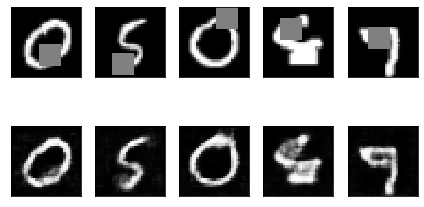

epoch = 2/100, d_loss=0.263, g_loss=0.639                                                                                                                      
epoch = 3/100, d_loss=0.358, g_loss=0.449                                                                                                                      
epoch = 4/100, d_loss=0.121, g_loss=0.942                                                                                                                      
epoch = 5/100, d_loss=0.767, g_loss=0.306                                                                                                                      
epoch = 6/100, d_loss=0.129, g_loss=0.939                                                                                                                      
epoch = 7/100, d_loss=0.454, g_loss=0.325                                                                                                                      
epoch = 8/100, d_loss=0.118, g_loss=0.93

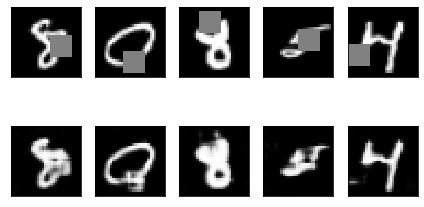

Exception ignored in: <bound method IteratorResourceDeleter.__del__ of <tensorflow.python.data.ops.iterator_ops.IteratorResourceDeleter object at 0x7f0eacadddd8>>
Traceback (most recent call last):
  File "/home/paracosma/.virtualenvs/dl4cv/lib/python3.6/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 537, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/home/paracosma/.virtualenvs/dl4cv/lib/python3.6/site-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1279, in delete_iterator
    tld.op_callbacks, handle, deleter)
KeyboardInterrupt: 


KeyboardInterrupt: 

In [26]:
epochs = 100
batch_size = 64
smooth = 0.1

real = np.ones((batch_size, 4, 4, 1))
real = real * (1 - smooth)
fake = np.zeros((batch_size, 4, 4, 1))

fake_labels = to_categorical(np.full((batch_size, 1), num_classes), num_classes=num_classes+1)

d_loss = []
d_g_loss = []

for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):
        
        # Train Discriminator weights
        discriminator.trainable = True
        
        # Real samples
        img_real = X_train[i*batch_size:(i+1)*batch_size]
        real_labels = y_train[i*batch_size:(i+1)*batch_size]
        
        d_loss_real = discriminator.train_on_batch(x=img_real, y=[real, real_labels])
        
        # Fake Samples
        masked_imgs = mask_randomly(img_real)
        gen_imgs = generator.predict(masked_imgs)
        
        d_loss_fake = discriminator.train_on_batch(x=gen_imgs, y=[fake, fake_labels])
         
        # Discriminator loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        
        # Train Generator weights
        discriminator.trainable = False

        d_g_loss_batch = d_g.train_on_batch(x=masked_imgs, y=real)
   
        print(
            'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, d_g_loss_batch[0]),
            100*' ',
            end='\r'
        )
    
    d_loss.append(d_loss_batch)
    d_g_loss.append(d_g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], d_g_loss[-1]), 100*' ')

    if e % 10 == 0:
        samples = 5
        idx = np.random.randint(0, X_train.shape[0], samples)
        masked_imgs = mask_randomly(X_train[idx])
        x_fake = generator.predict(masked_imgs)

        for k in range(samples):
            # plot masked
            plt.subplot(2, 5, k+1)
            plt.imshow(masked_imgs[k].reshape(32, 32), cmap='gray')
            plt.xticks([])
            plt.yticks([])

            # plot recontructed
            plt.subplot(2, 5, k+6)
            plt.imshow(x_fake[k].reshape(32, 32), cmap='gray')
            plt.xticks([])
            plt.yticks([])

        plt.tight_layout()
        plt.show()
